## Exercício: Modelo de Linguagem com auto-atenção

Este exercício é similar ao da aula passada, mas iremos agora treinar uma rede neural *com auto-atenção* para prever a próxima palavra de um texto, data as palavras anteriores como entrada.

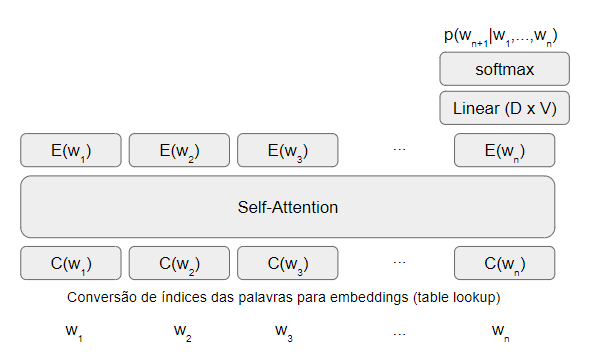

Na camada de auto-atenção, deve-se implementar (vide slide 41):
- Embeddings de posição
- Projeções lineares (WQ, WK, WV, WO)
- Camada de feed forward (2-layer MLP)



Instrucões:
- É necessário fazer duas implementações da camada de auto-atenção: uma usando laços (ineficiente, mas fácil de entender) e outra matricial (eficiente mas difícil de entender). Usar slide 41 como referência.

- Fazer um assert para garantir que o resultado das duas implementações é exatamente igual.

- No treinamento, usar apenas a implementação matricial.

## Faz download e carrega o dataset

In [ ]:
!git clone https://github.com/ethelbeluzzi/projetomachado

Cloning into 'projetomachado'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 65 (delta 24), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (65/65), 7.21 MiB | 3.80 MiB/s, done.
Resolving deltas: 100% (24/24), done.


In [ ]:
import os
# >>> Análise varia dependendo do formato que os dados são fornecidos <<<

DATA_PATH = os.path.join("projetomachado", "textonormalizado1000.txt")

# Abrir arquito textual e ler os dados originais
with open(DATA_PATH, "r") as data_file:
    data_text = data_file.read()

# Número total de caracteres no dataset
len(data_text)

18845445

In [ ]:
# Limpar texto: remover espaços desnecessários, substituir reticências
cleaned_text = data_text.replace("...", "*").replace('\n', ' ').strip().lower() # Substituição de ... por * para não gerar 3 pontos individuais.

cleaned_text[:1000]

'1 ministério da cultura fundação biblioteca nacional departamento nacional do livro a mão e a luva machado de assis i o fim da carta mas que pretendes fazer agora? morrer. morrer? que idéia! deixate disso, estêvão. não se morre por tão pouco* morrese. quem não padece estas dores não as pode avaliar. o golpe foi profundo, e o meu coração é pusilânime; por mais aborrecível que pareça a idéia da morte, pior, muito pior do que ela, é a de viver. ah! tu não sabes o que isto é? sei: um namoro gorado* luís! * e se em cada caso de namoro gorado morresse um homem, tinha já diminuído muito o gênero humano, e malthus perderia o latim. anda, sobe. estêvão meteu a mão nos cabelos com um gesto de angústia; luís alves sacudiu a cabeça e sorriu. achavamse os dois no corredor da casa de luís alves, à rua da constituição,  que então se chamava dos ciganos;  então, isto é, em 1853, uma bagatela de vinte anos que lá vão, levando talvez consigo as ilusões do leitor, e deixandolhe em troca usurários! uma t

In [ ]:
from collections import Counter
import re
# Contar número de palavras ÚNICAS
def count_words(text):
    # Counter: collection especifica do Python para contar ocorrências de um objeto
    word_counts = Counter()
    word_counts.update(re.findall(r'\w+|[.,!?:;*]', text)) # * representa ...

    return word_counts

word_counts = count_words(cleaned_text)

In [ ]:
word_counts['*']

15245

## Criando um vocabulário

In [ ]:
vocab_size = 2000
most_frequent_words = [word for word, count in word_counts.most_common(vocab_size)]
vocab = {word: i for i, word in enumerate(most_frequent_words, 1)}
most_frequent_words[:5]

[',', '.', 'a', 'que', 'de']

In [ ]:
# Separar o texto completo em treino e validação
# limit = int(0.8 * len(cleaned_text))
# train_text = cleaned_text[:limit]
# val_text = cleaned_text[limit:]

# Tokenização

In [ ]:
import random
def encode_sentence(sentence, vocab):
    # Usa regex para separar palavras (sequências alfanuméricas e pontuação)
    return [vocab.get(word, 0) for word in re.findall(r'\w+|[.,!?:;*]', sentence.strip().lower())]

# Exemplo de tokenização
random_start = random.randint(0, len(cleaned_text) - 100)  # Escolhe um ponto aleatório no texto completo
random_sentence = cleaned_text[random_start:random_start + 100]  # Extrai uma sequência de 100 caracteres a partir desse ponto
encoded_sentence = encode_sentence(random_sentence, vocab)

print(f"{random_sentence}\n{encoded_sentence}")

cartucho de pralinas constitucionais, abarrotouse, e nem por isso teve indigestão, ao contrário, dig
[0, 5, 0, 0, 1, 0, 1, 6, 42, 25, 96, 284, 0, 1, 24, 421, 1, 0]


In [ ]:
def decode_sentence(indices, idx_to_word):
    # Converte uma lista de índices para suas palavras correspondentes
    return ' '.join([idx_to_word.get(idx, '<UNK>') for idx in indices])

# Exemplo de uso:
# Suponha que generated_indices seja a lista de índices gerada pelo seu modelo
generated_indices = [3, 7, 12, 15, 2, 10, 0]  # Exemplo de índices

# O dicionário idx_to_word mapeia os índices para palavras
idx_to_word = {idx: word for word, idx in vocab.items()}

# Decodificar a sequência de índices para texto
decoded_text = decode_sentence(generated_indices, idx_to_word)

print(f"{generated_indices}\n{decoded_text}")

[3, 7, 12, 15, 2, 10, 0]
a o da com . um <UNK>


## Classe do dataset

In [ ]:
from torch.utils.data import Dataset

context_size = 5 # 5 palavras de entrada. O target é a próxima palavra
"""TODO: Preparar o dataset"""
class TextDataset(Dataset):
    """
    Dataset para a tarefa de modelagem de linguagem com pares (contexto, target).

    Args:
        text (str): Texto completo a ser usado para gerar os pares.
        vocab (dict): Dicionário de vocabulário, mapeando palavras para índices.
        context_size (int): Tamanho do contexto (número de palavras).

    Attributes:
        pairs (list): Lista de pares (contexto, target) onde contexto é uma lista de índices e target é um índice.
    """

    def __init__(self, text, vocab, context_size):
        self.pairs = self.create_context_target_pairs(text, vocab, context_size)

    def create_context_target_pairs(self, text, vocab, context_size):
        context_target_pairs = []

        # Tokenizar o texto completo
        tokens = encode_sentence(text, vocab)

        # Gerar pares (contexto, target) ignorando targets desconhecidos
        for i in range(len(tokens) - context_size):
            context = tokens[i:i + context_size]
            target = tokens[i + context_size]

            # Adiciona o par apenas se o target não for unknown (0)
            if target != 0:
                context_target_pairs.append((context, target))

        return context_target_pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        context, target = self.pairs[idx]
        return torch.tensor(context, dtype=torch.long), torch.tensor(target, dtype=torch.long)

In [ ]:
"""TODO: divida o dataset em validação/treino com um proporção de 20/80 %. OBS, use random_state=18"""
from sklearn.model_selection import train_test_split
# Dividir as linhas limpas em treino e validação (80/20)

# Função para dividir o texto em palavras
def split_text_into_words(text):
    return re.findall(r'\w+|[.,!?:;*]', text.lower())

# Função para juntar palavras em texto
def join_words_to_text(words):
    return ' '.join(words)

# Dividir o texto em palavras
words = split_text_into_words(cleaned_text)

# Dividir as palavras em treino e validação (80/20)
train_words, val_words = train_test_split(words, test_size=0.2, random_state=18, shuffle=False)

# Juntar as palavras de volta em texto para treino e validação
train_cleaned_text = join_words_to_text(train_words)
val_cleaned_text = join_words_to_text(val_words)

In [ ]:
"""TODO: implemente a classe do dataset"""
import torch

train_data = TextDataset(train_cleaned_text, vocab, context_size)
val_data = TextDataset(val_cleaned_text, vocab, context_size)

In [ ]:
# Exemplo de acesso a um item do dataset
for i in range(3):
  sample_context, sample_target = train_data[i]
  print(f"Contexto: {sample_context}, Target: {sample_target}")

for i in train_words[:15]:
  print(encode_sentence(i, vocab), end=' ')
print()

Contexto: tensor([1369, 1376,   12,    0,    0]), Target: 1631
Contexto: tensor([1376,   12,    0,    0, 1631]), Target: 1490
Contexto: tensor([   0,    0, 1631, 1490,    0]), Target: 1490
[1369] [1376] [12] [0] [0] [1631] [1490] [0] [1490] [11] [243] [3] [136] [6] [3] 


In [ ]:
print(len(train_words))
print(len(val_words))
print(len(train_data))
print(len(val_data))

3137239
784310
2560297
643198


In [ ]:
# Função para validar se nenhum par contém o token 0 (token desconhecido)
def validate_no_unknown_tokens(dataset):
    for i in range(len(dataset)):
        context, target = dataset[i]
        assert target != 0, f"Target contém token desconhecido (0) no índice {i}: {target}"

# Validando o dataset de treino e validação
validate_no_unknown_tokens(train_data)
validate_no_unknown_tokens(val_data)

print("Todos os targets estão livres de tokens desconhecidos (0).")

Todos os targets estão livres de tokens desconhecidos (0).


In [ ]:
from torch.utils.data import DataLoader

batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
sample = next(iter(train_loader))

In [ ]:
context_batch, target_batch = sample

print(f"Dimensões do contexto no lote: {context_batch.shape}")
print(f"Dimensões do alvo no lote: {target_batch.shape}")
sample[0][0], sample[1][0]

Dimensões do contexto no lote: torch.Size([32, 5])
Dimensões do alvo no lote: torch.Size([32])


(tensor([  2,   0,  22, 333,   0]), tensor(6))

## Model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import math

class PositionalEncoding(nn.Module):
    "Implement the PE function."

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1)].requires_grad_(False)
        return x

class LanguageModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, ff_hidden_dim, context_size):
        super(LanguageModel, self).__init__()

        self.embed_dim = embed_dim
        self.context_size = context_size
        self.embedding = nn.Embedding(vocab_size+1, embed_dim)
        self.positional_encoding = PositionalEncoding(embed_dim, max_len=context_size)

        # Inicializar as camadas de projeção
        self.wq = nn.Linear(embed_dim, embed_dim, bias=False)
        self.wk = nn.Linear(embed_dim, embed_dim, bias=False)
        self.wv = nn.Linear(embed_dim, embed_dim, bias=False)
        self.wo = nn.Linear(embed_dim, embed_dim, bias=False)

        # Camada feed-forward (2-layer MLP)
        self.feed_forward = nn.Sequential(
            nn.Linear(context_size*embed_dim, ff_hidden_dim),
            nn.ReLU(),
            nn.Linear(ff_hidden_dim, vocab_size+1)
        )



    def attention_loop(self, X):
        batch_size, L, dk = X.size()
        E = []

        for i in range(L):
            xq = X[:, i, :]  # shape: (batch_size, embed_dim)
            q = self.wq(xq).unsqueeze(1)
            scores = torch.zeros(batch_size, L, device=X.device)

            for j in range(L):
                xk = X[:, j, :]
                k = self.wk(xk).unsqueeze(1)
                scores[:, j] = torch.matmul(q, k.transpose(-2, -1)).squeeze(1).squeeze(1)/math.sqrt(dk)

            probs = F.softmax(scores, dim=-1)
            e = torch.zeros(batch_size, self.embed_dim, device=X.device)

            for j in range(L):
                xv = X[:, j, :]
                v = self.wv(xv)
                e += v * probs[:, j].unsqueeze(-1)

            e = self.wo(e)
            E.append(e)
        return torch.stack(E, dim=1)

    def attention_matrix(self, Q, K, V):
        dk = K.size(-1)
        scores = torch.matmul(Q, K.transpose(-2, -1))/math.sqrt(dk)  # shape: (L, L)
        probs = F.softmax(scores, dim=-1)  # shape: (L, L)
        E = torch.matmul(probs, V)  # shape: (L, D)
        E = self.wo(E)
        return E

    def forward(self, X, version="matrix"):
        # X deve ter tamanho (context_size, embed_dim)
        # Adicionar embeddings de posição
        X = self.embedding(X)
        X = self.positional_encoding(X)

        # Obtenha Q, K, V
        Q = self.wq(X)
        K = self.wk(X)
        V = self.wv(X)

        if version == "loop":
            E = self.attention_loop(X)
        elif version == "matrix":
            E = self.attention_matrix(Q, K, V)
        else:
            raise ValueError("Versão desconhecida. Escolha 'loop' ou 'matrix'.")
        E = E.view(E.size(0), -1)
        # Aplicar a camada feed-forward
        return self.feed_forward(E)

In [ ]:
embed_dim = 64
ff_hidden_dim = 128
context_size = 5
vocab_size = 2000

model = LanguageModel(vocab_size, embed_dim, ff_hidden_dim, context_size)

In [ ]:
# sample = next(iter(train_loader))
input = sample[0]
target = sample[1]
input.shape

torch.Size([32, 5])

In [ ]:
output1 = model(input,version="loop")
output2 = model(input,version="matrix")
are_equal = torch.allclose(output1, output2, atol=1e-6)  # Verifica se os resultados são próximos
are_equal

True

In [ ]:
print(model)

LanguageModel(
  (embedding): Embedding(2001, 64)
  (positional_encoding): PositionalEncoding()
  (wq): Linear(in_features=64, out_features=64, bias=False)
  (wk): Linear(in_features=64, out_features=64, bias=False)
  (wv): Linear(in_features=64, out_features=64, bias=False)
  (wo): Linear(in_features=64, out_features=64, bias=False)
  (feed_forward): Sequential(
    (0): Linear(in_features=320, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=2001, bias=True)
  )
)


In [ ]:
total_params = 0
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.size()} - {param.numel()} parâmetros")
        total_params += param.numel()

print(f"Número total de parâmetros: {total_params}")

embedding.weight: torch.Size([2001, 64]) - 128064 parâmetros
wq.weight: torch.Size([64, 64]) - 4096 parâmetros
wk.weight: torch.Size([64, 64]) - 4096 parâmetros
wv.weight: torch.Size([64, 64]) - 4096 parâmetros
wo.weight: torch.Size([64, 64]) - 4096 parâmetros
feed_forward.0.weight: torch.Size([128, 320]) - 40960 parâmetros
feed_forward.0.bias: torch.Size([128]) - 128 parâmetros
feed_forward.2.weight: torch.Size([2001, 128]) - 256128 parâmetros
feed_forward.2.bias: torch.Size([2001]) - 2001 parâmetros
Número total de parâmetros: 443665


## Training

In [ ]:
# Verifica se há uma GPU disponível e define o dispositivo para GPU se possível, caso contrário, usa a CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
#""" TODO: calcule a perplexidade final no dataset de validação """
import numpy as np
model.to(device)
criterion = nn.CrossEntropyLoss() #"""TODO CrossEntropy""""
def calculate_perplexity(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_words = 0

    with torch.no_grad():
        for contexts, targets in dataloader:
            contexts, targets = contexts.to(device), targets.to(device)

            # Forward pass
            outputs = model(contexts, version="matrix")

            # Calculate the loss
            loss = criterion(outputs, targets)

            # Accumulate the loss and the number of words
            total_loss += loss.item() * contexts.size(0)
            total_words += targets.size(0)

    # Compute the average loss
    avg_loss = total_loss / total_words

    # Calculate the perplexity
    perplexity = np.exp(avg_loss)

    return perplexity

# Exemplo de uso
train_perplexity = calculate_perplexity(model, train_loader, criterion, device)
print(f"Perplexidade no conjunto de treino: {train_perplexity:.2f}")

Perplexidade no conjunto de treino: 1998.84


Epoch 1/10 - Train Loss: 4.5573 - Val Loss: 4.4519 - Train Accuracy: 0.1533 - Val Accuracy: 0.1659
Epoch 2/10 - Train Loss: 4.3634 - Val Loss: 4.4019 - Train Accuracy: 0.1675 - Val Accuracy: 0.1714
Epoch 3/10 - Train Loss: 4.3155 - Val Loss: 4.3659 - Train Accuracy: 0.1720 - Val Accuracy: 0.1742
Epoch 4/10 - Train Loss: 4.2952 - Val Loss: 4.3723 - Train Accuracy: 0.1741 - Val Accuracy: 0.1740
Epoch 5/10 - Train Loss: 4.2842 - Val Loss: 4.3516 - Train Accuracy: 0.1753 - Val Accuracy: 0.1766
Epoch 6/10 - Train Loss: 4.2775 - Val Loss: 4.3429 - Train Accuracy: 0.1760 - Val Accuracy: 0.1762
Epoch 7/10 - Train Loss: 4.2730 - Val Loss: 4.3537 - Train Accuracy: 0.1762 - Val Accuracy: 0.1777
Epoch 8/10 - Train Loss: 4.2696 - Val Loss: 4.3418 - Train Accuracy: 0.1765 - Val Accuracy: 0.1773
Epoch 9/10 - Train Loss: 4.2671 - Val Loss: 4.3313 - Train Accuracy: 0.1770 - Val Accuracy: 0.1779
Epoch 10/10 - Train Loss: 4.2643 - Val Loss: 4.3431 - Train Accuracy: 0.1772 - Val Accuracy: 0.1774


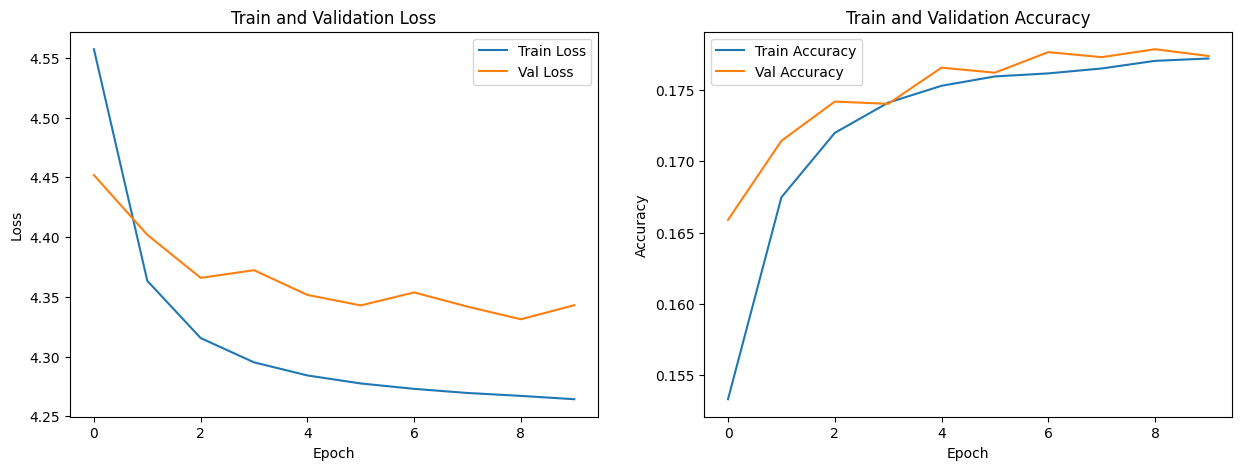

In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt

epochs = 10
lr = 1e-3 #"""TODO, experimente!""""
criterion = nn.CrossEntropyLoss() #"""TODO CrossEntropy""""

optimizer = optim.AdamW(model.parameters(), lr=lr) #"""TODO: AdamW ou outro, experimente!""""

model.to(device)

#"""TODO: Implemente o loop de treinamento. Em cada época, calcule e imprima a loss no dataset de validação. Opcional: Plote um gráfico da loss de validação e treino""""
# Função de Treinamento
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0.0
    correct = 0
    total = 0

    for contexts, targets in dataloader:
        contexts, targets = contexts.to(device), targets.to(device)

        optimizer.zero_grad()

        outputs = model(contexts, version="matrix")

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * contexts.size(0)

        # Cálculo da acurácia
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    accuracy = correct / total
    return epoch_loss / len(dataloader.dataset), accuracy

# Função de Avaliação
def evaluate(model, dataloader, criterion, device):
    model.eval()
    epoch_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for contexts, targets in dataloader:
            contexts, targets = contexts.to(device), targets.to(device)

            outputs = model(contexts, version="matrix")

            loss = criterion(outputs, targets)
            epoch_loss += loss.item() * contexts.size(0)

            # Cálculo da acurácia
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    accuracy = correct / total
    return epoch_loss / len(dataloader.dataset), accuracy

# Loop de Treinamento e Avaliação
def train_and_evaluate(model, train_loader, val_loader, optimizer, criterion, epochs, device):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - "
              f"Train Accuracy: {train_acc:.4f} - Val Accuracy: {val_acc:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies

# Treinamento e Avaliação
train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate(model, train_loader, val_loader, optimizer, criterion, epochs, device)

# Plotar Gráficos de Loss e Acurácia
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Plot de Loss
    axs[0].plot(train_losses, label='Train Loss')
    axs[0].plot(val_losses, label='Val Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Train and Validation Loss')
    axs[0].legend()

    # Plot de Acurácia
    axs[1].plot(train_accuracies, label='Train Accuracy')
    axs[1].plot(val_accuracies, label='Val Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_title('Train and Validation Accuracy')
    axs[1].legend()

    plt.show()

plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

## Avaliação

In [ ]:
""" TODO: calcule a perplexidade final no dataset de validação """
val_perplexity = calculate_perplexity(model, val_loader, criterion, device)
print(f"Perplexidade no conjunto de validação: {val_perplexity:.2f}")

Perplexidade no conjunto de validação: 76.94


## Exemplo de uso

In [ ]:
def generate_text(model, vocab, start_text, max_length, context_size, device):
    model.eval()

    # Codifique o texto inicial
    context = encode_sentence(start_text, vocab)

    # Garantir que o tamanho do contexto esteja correto
    if len(context) < context_size:
        raise ValueError(f"O contexto inicial deve ter pelo menos {context_size} palavras.")

    generated_indices = []
    # Começar a geração de texto
    for _ in range(max_length):
        # Obter o contexto atual
        input_context = torch.tensor([context[-context_size:]], dtype=torch.long, device=device)

        # Forward pass
        with torch.no_grad():
            output = model(input_context, version="matrix")

        # Obter a palavra mais provável
        predicted_index = torch.argmax(output, dim=-1).item()

        # Adicionar a palavra ao texto gerado
        generated_indices.append(predicted_index)

        # Atualizar o contexto
        context.append(predicted_index)
        context = context[-context_size:]

    return start_text+' '+decode_sentence(generated_indices, idx_to_word)

def get_random_context(val_cleaned_text, context_size):
    # Divida o texto em palavras
    words = split_text_into_words(val_cleaned_text)

    # Verifique se há pelo menos `context_size` palavras
    if len(words) < context_size:
        raise ValueError(f"O texto deve ter pelo menos {context_size} palavras.")

    # Escolha uma posição aleatória para começar
    start_index = random.randint(0, len(words) - context_size)

    # Pegue as palavras do contexto
    context = words[start_index:start_index + context_size]

    # Converta as palavras em texto
    context_text = join_words_to_text(context)

    return context_text

# Exemplo de uso
text = get_random_context(val_cleaned_text, context_size)
print("Contexto Inicial:", text)
max_length= 50
generated_text = generate_text(model, vocab, text, max_length, context_size, device)
print(f"Texto gerado: {generated_text}")

Contexto Inicial: santa teresa , quando ele
Texto gerado: santa teresa , quando ele não lhe não não , nem a que a não , nem a que a não , nem a que a não , nem a que a não , nem a que a não , nem a que a não , nem a que a não , nem a que
